In [22]:
import os 
import glob 

import numpy as np
import pandas as pd

from metpy.calc import wind_speed
from metpy.calc import wind_direction 
from metpy.units import units

import matplotlib.pyplot as plt
from   matplotlib.lines import Line2D
import seaborn as sns

sns.set_theme(style="whitegrid")

# Set up working directory - adjust this to where the repo is stored locally
%cd '/Users/patmccornack/Documents/ucsb_fog_project/_repositories/sci-wrf-analysis'

/Users/patmccornack/Documents/ucsb_fog_project/_repositories/sci-wrf-analysis


# About  
__Author:__ Pat McCornack

__Date:__ 12/26/24

__Description:__  
This notebook analyzes the difference between the interpolated* WRF outputs and the observational dataset. This includes looking at comparison statistics, cumulative distribution functions, scatter plots, and timeseries lineplots.

Interpolation was done during data extraction from the WRF netcdf files. In an attempt to better represent the station elevation, bilinear interpolation was done to the station point using the nearest 4 grid cell centers. In another analysis, we found that this method does not do well to approximate the station elevation. The 1 sq km grid scale averages multiple ridges and valleys, with the net result being that bilinear inteprolation yields an elevation lower than the actual station elevation and therefore misrepresents values. Ultimately it does not perform better than simply using the nearest point. 

__Findings Summary:__  
Interpolating the WRF data to the station coordinates does not yield better results than simply using the nearest point to the station. 

__Outputs:__  
Saves out a dataframe of the comparison statistics for each variable and site. 


# Functions

## Read in data

In [23]:
def prep_wrf_data(fpath, var_name_dict, site):
    """
    Reads and prepares WRF data

    Reads in data, convert temperature from K to C, casts index to DateTime format, calculates
    wind speed and direction, and returns the prepared dataframe

    Parameters
    ----------
    df_fpath : str
        Path to file containing the data.
    var_name_dict : dict
        Dictionary of variable rename mappings to.
    
    Returns
    -------
    pd.Dataframe
        The prepared dataframe. 
    """
    df = pd.read_pickle(fpath)
    df['T2'] = df['T2'] - 273  # Convert K to C
    df.index = df.index - pd.Timedelta(hours=8)  # UTC to local
    wnd_spd, wnd_dir = get_wind(df['U10'].values, df['V10'].values)
    df['WND_SPD'] = wnd_spd
    df['WND_DIR'] = wnd_dir
    df.rename(columns=var_name_dict, inplace=True)
    
    df.attrs['site'] = site
    df.attrs['source'] = 'wrf'
    
    return df

def prep_obs_data(fpath, site):
    """
    Reads and prepares WRF data

    Reads in data, convert temperature from K to C, casts index to DateTime format, calculates
    wind speed and direction, and returns the prepared dataframe

    Parameters
    ----------
    fpath : str
        Path to file containing the data.
    site : str 
        The site the data corresponds to.

    Returns
    -------
    pd.Dataframe
        The prepared dataframe. 
    """
    
    df = pd.read_csv(fpath, index_col='time (PST)')
    df.index = pd.to_datetime(df.index)
    
    df.attrs['site'] = site
    df.attrs['source'] = 'obs'
    
    return df

## Run calculations

In [24]:
def run_stats(df, var, site):
    """
    Calculates statistics comparing the observational data to the WRF data and returns as statistics in a dataframe.

    Statistics include: correlation, bias, root mean square error, and mean absolute error.

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe containing the observed and modeled datasets.
    var : str
        Variable name to compute statistics for. 
    site : str
        Site to compute statistics for.

    Returns
    -------
    pd.DataFrame
        Dataframe of statistics for that site and variable. Includes the site and variable as fields. 

    """
    # Subset to site and var
    df = df.loc[df['site'] == site]

    # Define validation/model data
    xval = df.loc[df['source']=='obs'][var].rename('val')
    ymod = df.loc[df['source']=='wrf'][var].rename('model')
    
    # Inner join
    df = pd.concat([xval, ymod], axis=1, join='inner')
    df.dropna(inplace=True)
    xval = df['val']
    ymod = df['model']
    
    # Calculate stats
    res = np.corrcoef(xval, ymod)
    corr = res[0,1]
    bias = (ymod - xval).mean()
    tmp = (ymod - xval)**2
    rmse = np.sqrt(tmp.mean())
    mabs = np.abs(ymod - xval).mean()
    # Return results
    results = { 
        'site' : [site],
        'variable' : [var],
        'correlation' : [round(corr, 2)],
        'bias' : [round(bias, 2)],
        'rmse' : [round(rmse, 2)],
        'mae' : [round(mabs, 2)]
    }
    
    df = pd.DataFrame(results)
    return df

def get_wind(u, v): 
    """"
    Calculates wind speed and direction from velocity components

    Parameters
    -----------
    u : np.Series
        The x wind component.
    v : np.Series  
        The y wind component. 

    Returns
    -------
    wind_speed : float
        Calculated wind speed.
    wind_dir : float
        Calculated wind direction.
    """
    u = u * units('m/s')
    v = v * units('m/s')

    wnd_spd = wind_speed(u,v)
    wnd_dir = wind_direction(u, v, convention='from')
    
    return wnd_spd, wnd_dir

## Plotting functions

In [25]:
def plot_stats(stats_df, metric):
    """
    Plot bar charts for the supplied metric, broken down by variable and site. 

    Parameters
    ----------
    stats_df : pd.DataFrame
        Dataframe of statistics for each site/variable.
    metric : {'correlation', 'bias', 'rmse', 'mae'}
        Metric to plot.
    
    Returns
    -------
        None
    """
    g = sns.catplot(
        data=stats_df, kind="bar",
        x="variable", y=metric, hue="site",
        palette="tab10", alpha=.6, height=8
    )
    g.set_axis_labels("", metric)

    g.legend.set_title("")
    g.set(title=metric)
    plt.show()

    
def plot_cdf(df, var_list, site):
    """
    Plot cumulative distribution functions for both WRF and observational data for the given site and variables.

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe of observational and WRF data.
    var_list : list of str
        List of variables to plots CDFs for.
    site : str
        Site to plot CDF for. 
    
    Returns
    -------
        None
    """
    fig, ax = plt.subplots(2,2, figsize=(12,10))
    df = df.loc[df['site'] == site]
    idx = 0
    
    # make plots
    for row in [0,1]:
        for col in [0,1]:
            sns.ecdfplot(data=df.loc[df['source']=='wrf'], x=var_list[idx], ax=ax[row,col], color='blue', label='WRF')
            sns.ecdfplot(data=df.loc[df['source']=='obs'], x=var_list[idx], ax=ax[row,col], color='orange', label='Observed')
            idx+=1
    
    # make legend
    for axes in ax.flat:
        legend = axes.get_legend()
        if legend is not None:
            legend.remove()

    fig.legend(['WRF', 'Observed'], loc='center left', bbox_to_anchor=(1.05, 0.5), title='Source')
    fig.tight_layout(rect=[0, 0, 1, .97])
    
    fig.suptitle(site)
    

    plt.show()
    
def plot_scatter(df, var_list, site):
    """
    Plot scatterplots of WRF vs. Observational data for the given variables and sites.

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe of observational and WRF data.
    var_list : list of str
        List of variables to plot for.
    site : str
        Site to plot for. 
    
    Returns
    -------
        None
    """
    fig, ax = plt.subplots(2,2, figsize=(10,10))
    df = df.loc[df['site'] == site]
    idx=0
      
    for row in [0,1]:
        for col in [0,1]:
            # Join to drop missing
            x=df.loc[df['source']=='obs'][var_list[idx]].rename('obs')
            y=df.loc[df['source']=='wrf'][var_list[idx]].rename('model')
            join_df = pd.concat([x,y], axis=1, join='inner')

            # Plot
            ax[row, col].scatter(x=join_df['obs'],
                                 y=join_df['model'],
                                 alpha=0.25)
            ax[row,col].axline((1, 1), slope=1, color='black', linestyle='--')

            ax[row,col].set(xlabel='Observed',
                            ylabel='WRF',
                            title=f'{site} {var_list[idx]}')
            ax[row, col].axis('equal')
            idx+=1
            
    fig.tight_layout(rect=[0, 0, .97, .97])
    fig.suptitle(site)
    
    plt.show()
    

def plot_timeseries(df, var, daterange, site):
    """
    Plot timeseries lineplot for given variable, daterange, and site.

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe of observational and WRF data.
    var_list : list of str
        List of variables to plot for.
    daterange : list of str
        Date range to subset data to. Should be in the form [From, To], or ['YYYY-MM-DD','YYYY-MM-DD'].
    site : str
        Site to plot for. 
    
    Returns
    -------
        None
    """
    df = df.loc[df['site']==site]
    wdf = df.loc[df['source'] == 'wrf']
    odf = df.loc[df['source'] == 'obs']
    
    wdf = wdf[daterange[0] : daterange[1]]
    odf = odf[daterange[0] : daterange[1]]
    
    year = daterange[0].split('-')[0]
    month = daterange[0].split('-')[1]

    fig, ax = plt.subplots(figsize=(20,6))
    
    
    ax.plot(wdf.index, wdf[var], color='blue', label=f'WRF {var}')
    ax.plot(odf.index, odf[var], color='orange', label=f'Obs {var}')

    fig.legend(loc='upper right', bbox_to_anchor=(1.10, .99), bbox_transform=ax.transAxes)

    ax.set(title=f'Model vs. Observational {var}\n {site} {month}/{year}',
           ylabel=f'{var}')

    plt.show()

def plot_fog(fog_df, daterange, site):
    """
    Plot timeseries lineplot of relative humidity overlaid with a bar plot of fog events occurrence. Plots both WRF and Observational 
    on the same plot.

    Parameters
    ----------
    fog_df : pd.DataFrame
        Dataframe with fog and relative humidity observations.
    daterange : list of str
        Date range to subset data to. Should be in the form [From, To], or ['YYYY-MM-DD','YYYY-MM-DD'].
    site : str
        Site to plot for. 
    
    Returns
    -------
        None
    """
    wfog = fog_df.loc[fog_df['source'] == 'wrf']
    ofog = fog_df.loc[fog_df['source'] == 'obs']

    wfog = wfog[daterange[0] : daterange[1]]
    ofog = ofog[daterange[0] : daterange[1]]

    year = daterange[0].split('-')[0]
    month = daterange[0].split('-')[1]

    fig, ax = plt.subplots(figsize=(25, 8))
    ax2 = ax.twinx()
    ax.plot(wfog.index, wfog['relative humidity (%)'], color='blue', label='WRF RH')
    ax.plot(ofog.index, ofog['relative humidity (%)'], color='orange', label='Obs RH')

    ax2.bar(wfog.index, wfog['binary fog'], alpha=0.4, color='lightblue', width=0.1, label='WRF Fog')
    ax2.bar(ofog.index, ofog['binary fog'], alpha=0.2, color= 'gray', width=0.1, label='Obs Fog')
    ax2.get_yaxis().set_visible(False)

    ax.set(title=f'Model vs. Observational\n {site} {month}/{year}',
           ylabel=f'relative humidity (%)')

    fig.legend(loc='upper right', bbox_to_anchor=(1.09, .99), bbox_transform=ax.transAxes)
    plt.show()
    

# Overall Agreement

## Read in and Prepare Data

In [26]:
var_name_dict = {
    'DFGDP' : 'fog drip',
    'T2' : 'air temperature (C)',
    'RH' : 'relative humidity (%)',
    'WND_SPD' : 'wind speed (m/s)',
    'WND_DIR' : 'wind direction (deg)'
}

#### WRF file paths ####
wdatadir = './data/wrf-extracted/interpolated'
wsauc_fname = 'wrf-sauc-2003-2010.pkl'
wupem_fname = 'wrf-upem-2003-2010.pkl'
wnrs_sci_fname = 'wrf-nrs-2014-2019.pkl'

#### Obs file paths ####
odatadir = './data/observational'
osauc_fname = 'sauc-hourly.csv'
oupem_fname = 'upem-hourly.csv'
onrs_sci_fname = 'nrs-hourly.csv'

#### Read in data ####
wsauc = prep_wrf_data(os.path.join(wdatadir, wsauc_fname), var_name_dict, site='Sauces Canyon')
wupem = prep_wrf_data(os.path.join(wdatadir, wupem_fname), var_name_dict, site='Upper Embudo Canyon')
wnrs_sci = prep_wrf_data(os.path.join(wdatadir, wnrs_sci_fname), var_name_dict, site='NRS SCI')

osauc = prep_obs_data(os.path.join(odatadir, osauc_fname), site='Sauces Canyon')
oupem = prep_obs_data(os.path.join(odatadir, oupem_fname), site='Upper Embudo Canyon')
onrs_sci = prep_obs_data(os.path.join(odatadir, onrs_sci_fname), site='NRS SCI')

In [27]:
# Join all into a single dataframe
df_list = [wsauc, wupem, wnrs_sci, osauc, oupem, onrs_sci]
for df in df_list:
    df['site'] = df.attrs['site']
    df['source'] = df.attrs['source']

df = pd.concat(df_list, join='inner', axis=0)
df.head(2)

air temperature (C)  relative humidity (%)  \
2002-06-30 16:00:00            16.739721              87.413706   
2002-06-30 17:00:00            18.949653              74.233599   

                     wind speed (m/s)  wind direction (deg)           site  \
2002-06-30 16:00:00          3.005023            218.551773  Sauces Canyon   
2002-06-30 17:00:00          0.359815            125.791428  Sauces Canyon   

                    source  
2002-06-30 16:00:00    wrf  
2002-06-30 17:00:00    wrf

In [28]:
variables = ['air temperature (C)', 'relative humidity (%)', 'wind speed (m/s)', 'wind direction (deg)']
sites = ['Sauces Canyon', 'Upper Embudo Canyon', 'NRS SCI']

## Statistics

In [29]:
stats_df = pd.DataFrame()
for site in sites:
    for variable in variables:
        tmp = run_stats(df, variable, site)
        stats_df = pd.concat([stats_df, tmp], axis=0)
                     
stats_df['type'] = 'raw'
stats_df.to_csv('./data/outputs/comparison-stats/wrf-interpolated-stats.csv')
stats_df

site               variable  correlation   bias    rmse  \
0        Sauces Canyon    air temperature (C)         0.87   1.36    2.88   
0        Sauces Canyon  relative humidity (%)         0.81  -9.06   18.14   
0        Sauces Canyon       wind speed (m/s)         0.59   3.00    3.72   
0        Sauces Canyon   wind direction (deg)         0.54  -9.33   93.32   
0  Upper Embudo Canyon    air temperature (C)         0.89   1.55    3.06   
0  Upper Embudo Canyon  relative humidity (%)         0.83 -12.32   20.46   
0  Upper Embudo Canyon       wind speed (m/s)         0.63   3.03    3.66   
0  Upper Embudo Canyon   wind direction (deg)         0.63  -1.76   84.09   
0              NRS SCI    air temperature (C)         0.91   0.67    2.39   
0              NRS SCI  relative humidity (%)         0.82  -4.03   16.03   
0              NRS SCI       wind speed (m/s)         0.60  -0.18    2.18   
0              NRS SCI   wind direction (deg)         0.32  33.85  129.92   

     mae type  
0   2.11  raw  
0  13.28  raw  
0   3.11  raw  
0  55.06  raw  
0   2.23  raw  
0  15.03  raw  
0   3.05  raw  
0  52.35  raw  
0   1.84  raw  
0  11.45  raw  
0   1.65  raw  
0  92.61  raw

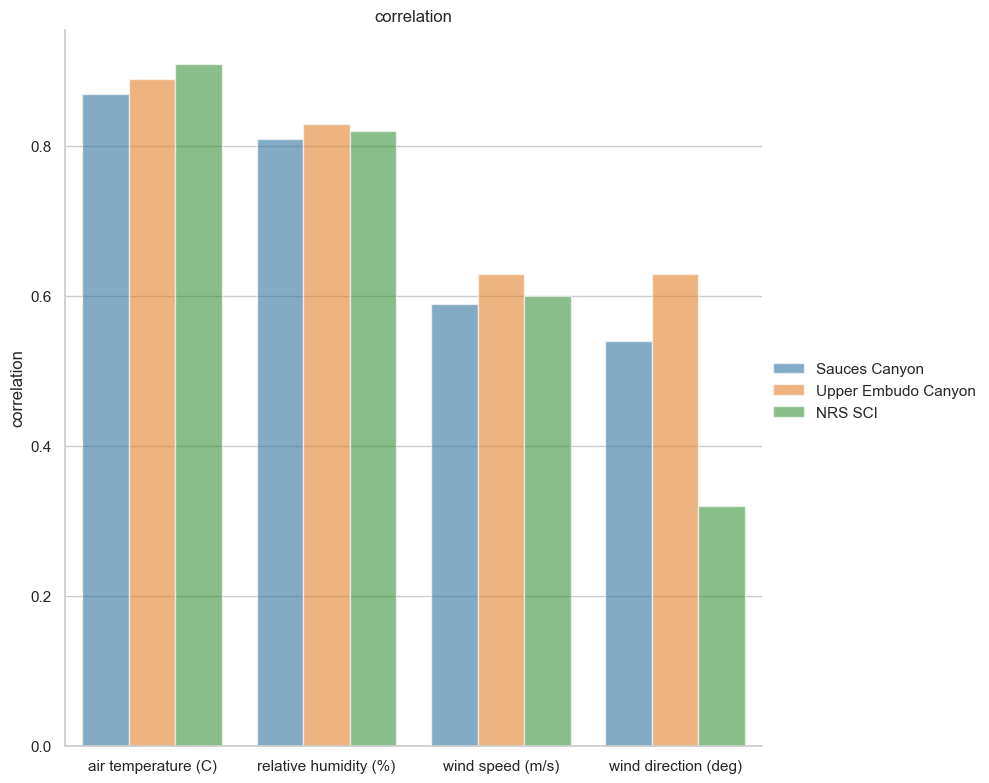

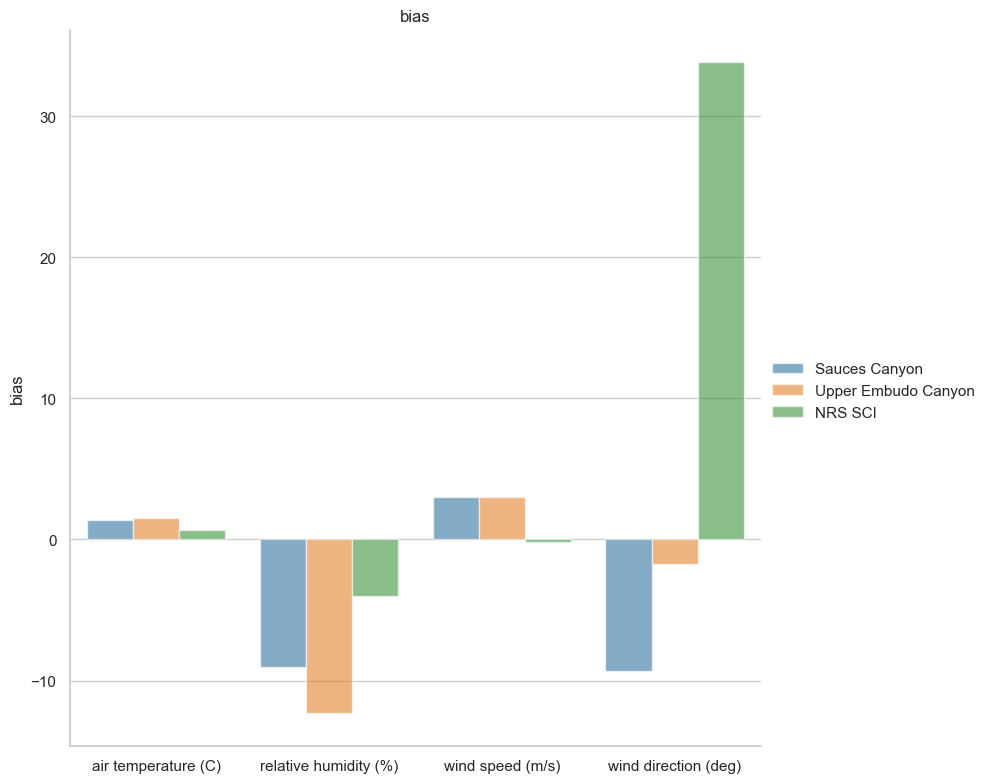

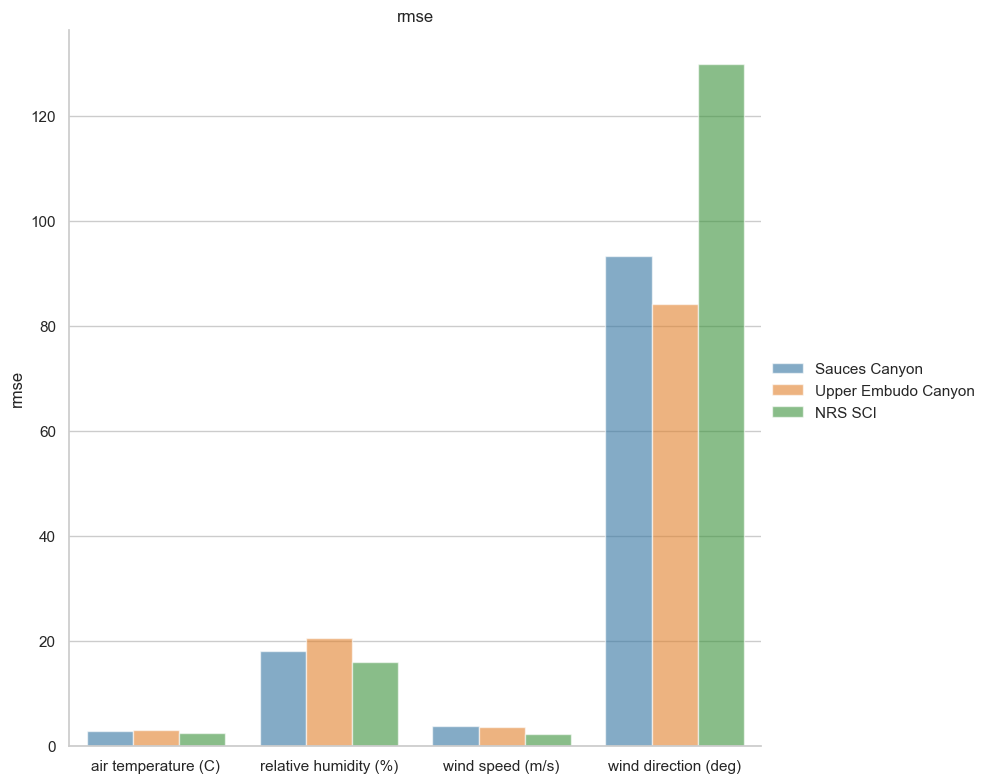

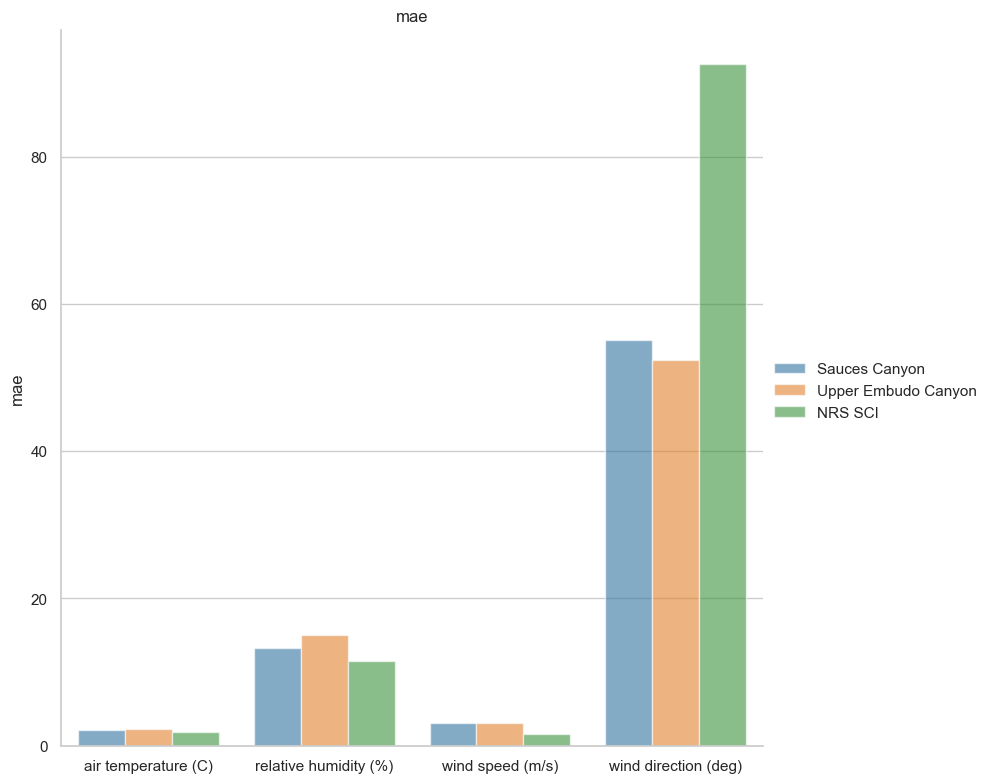

In [30]:
for metric in ['correlation', 'bias', 'rmse', 'mae']:
    plot_stats(stats_df, metric)

## CDF Plots

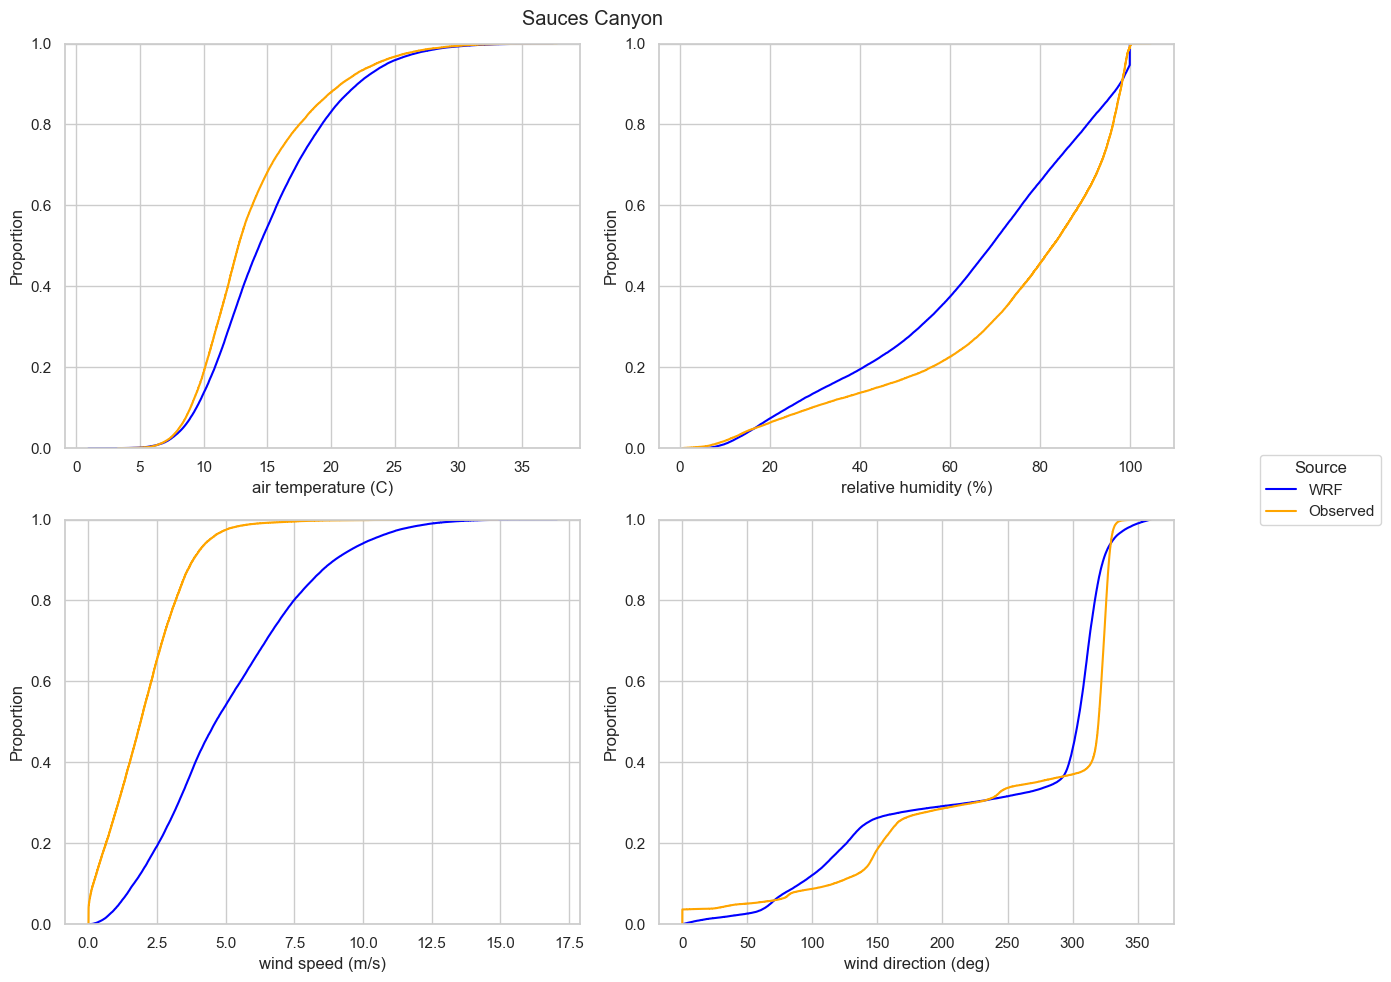

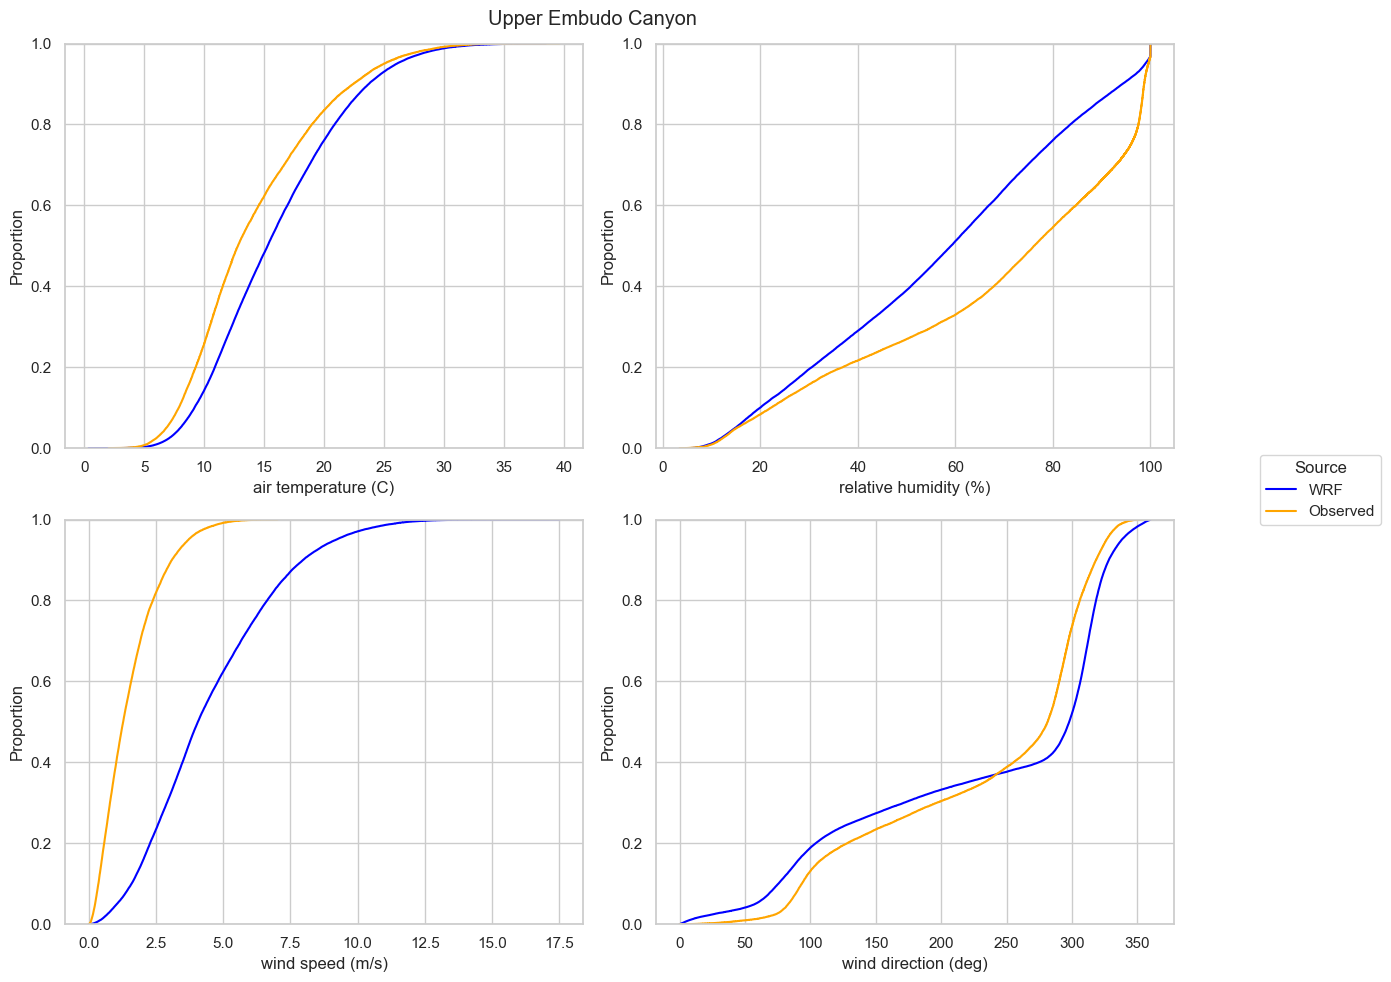

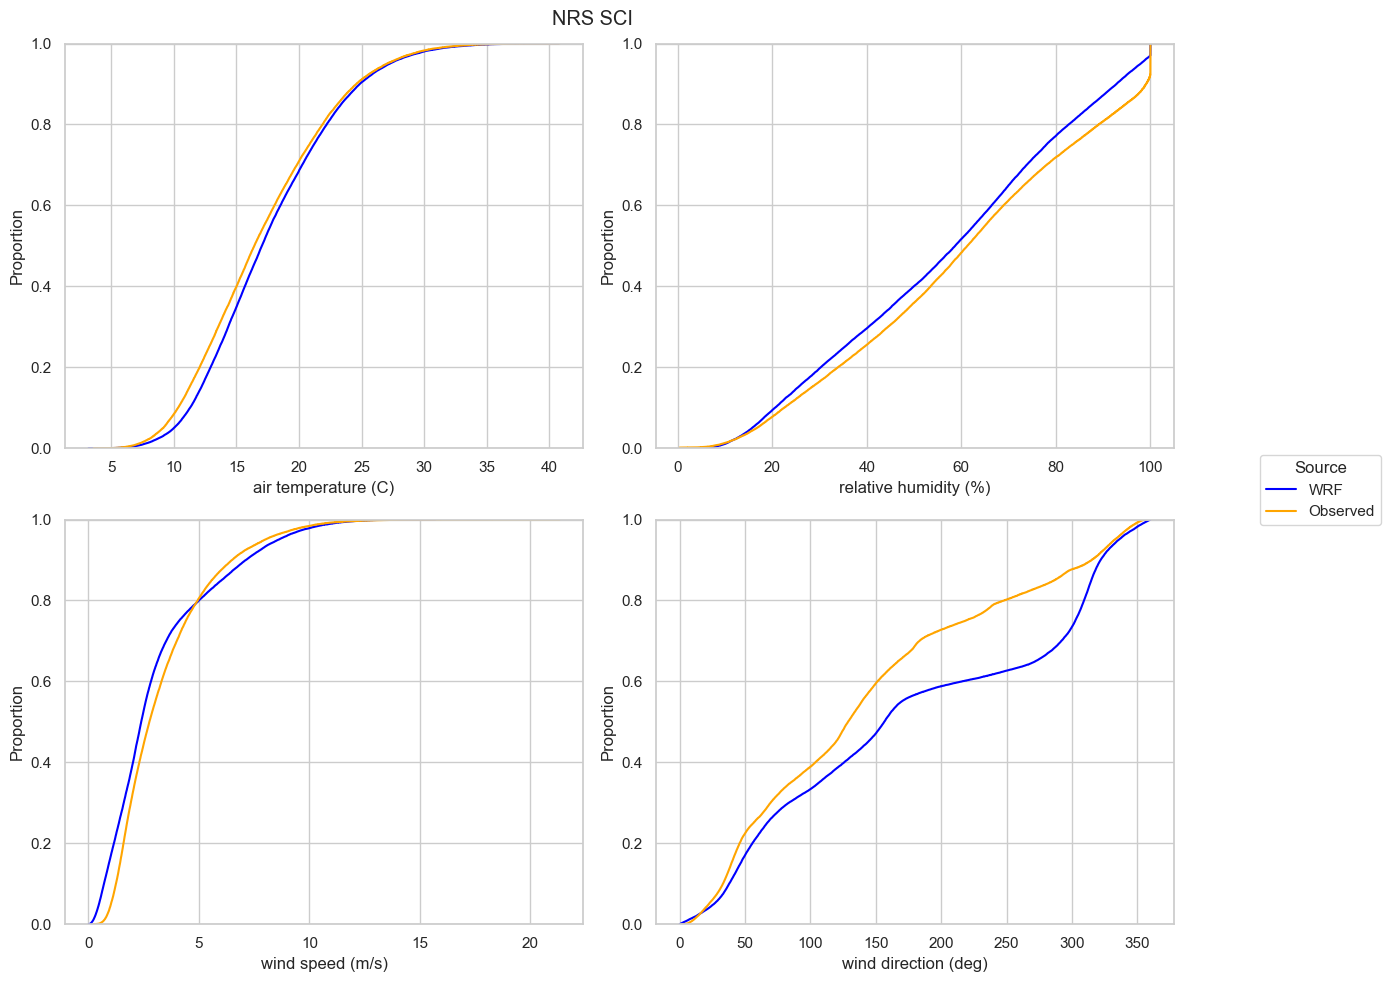

In [31]:
for site in sites:
    plot_cdf(df, variables, site)


## Scatter Plots

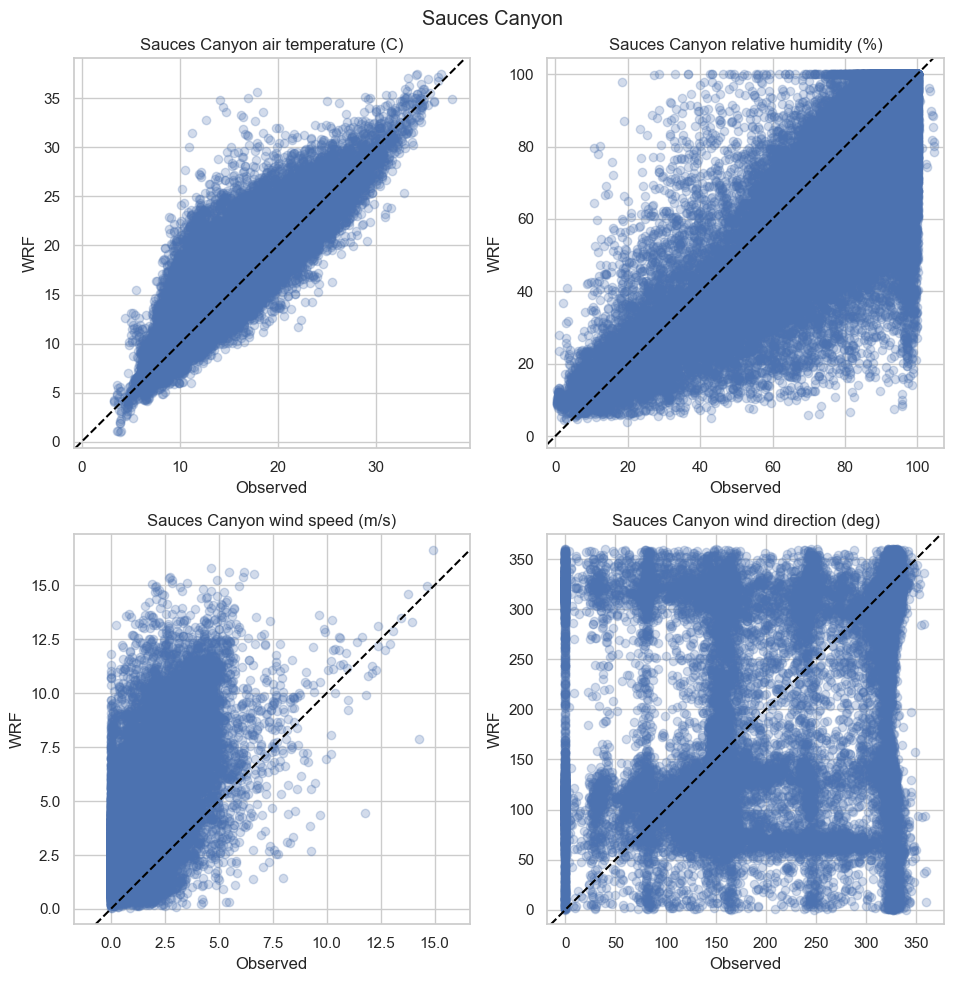

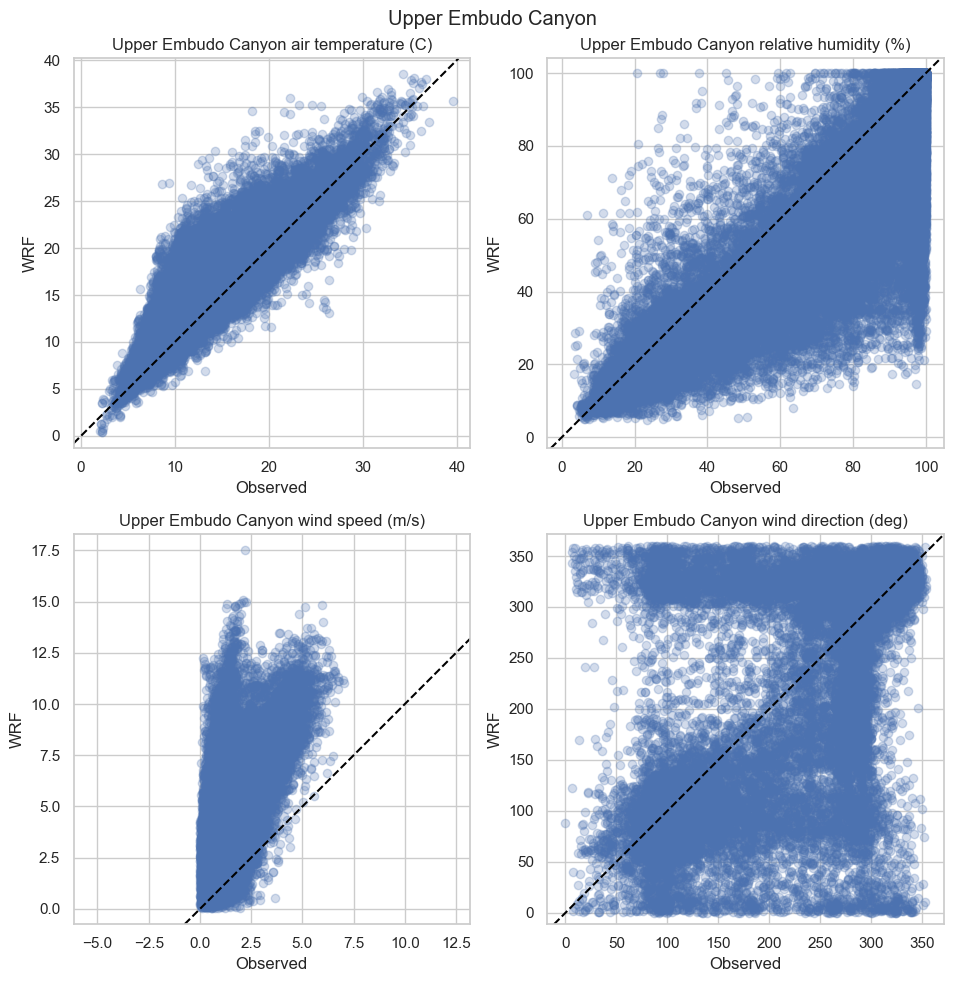

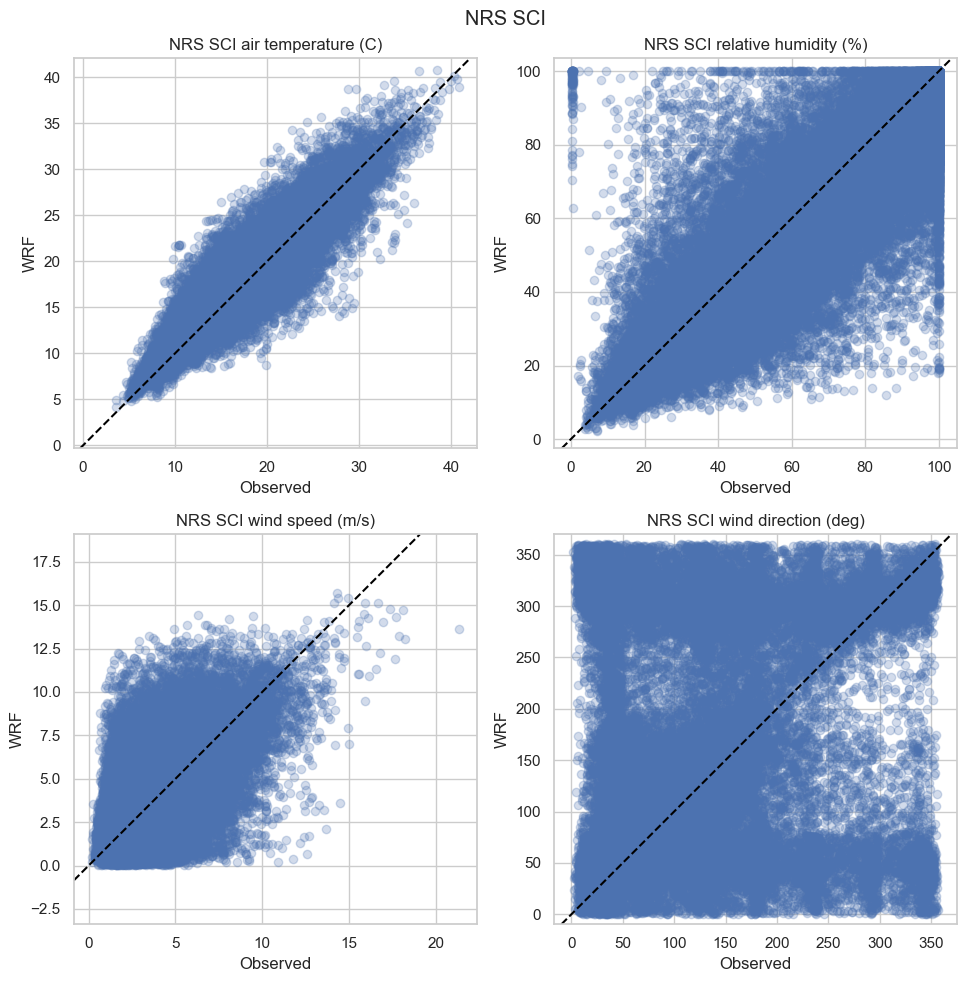

In [32]:
for site in sites:
    plot_scatter(df, variables, site)

## Time Series Plots

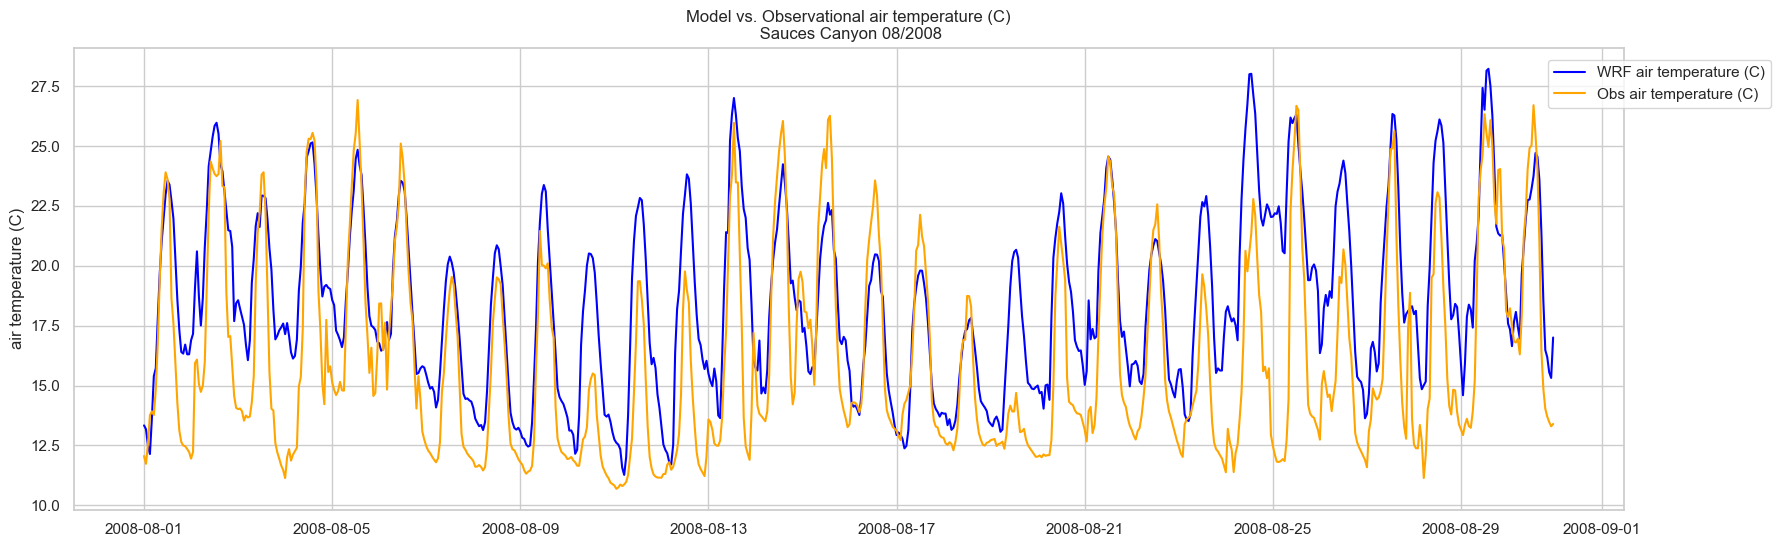

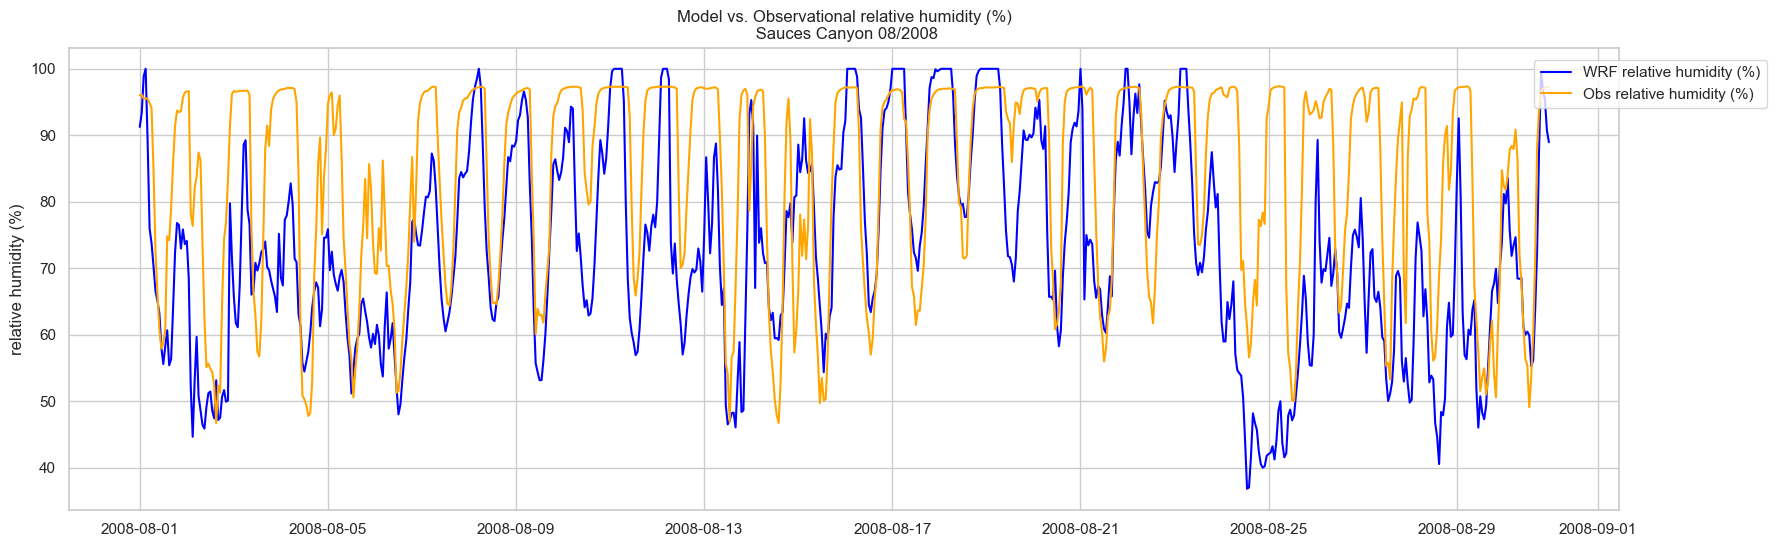

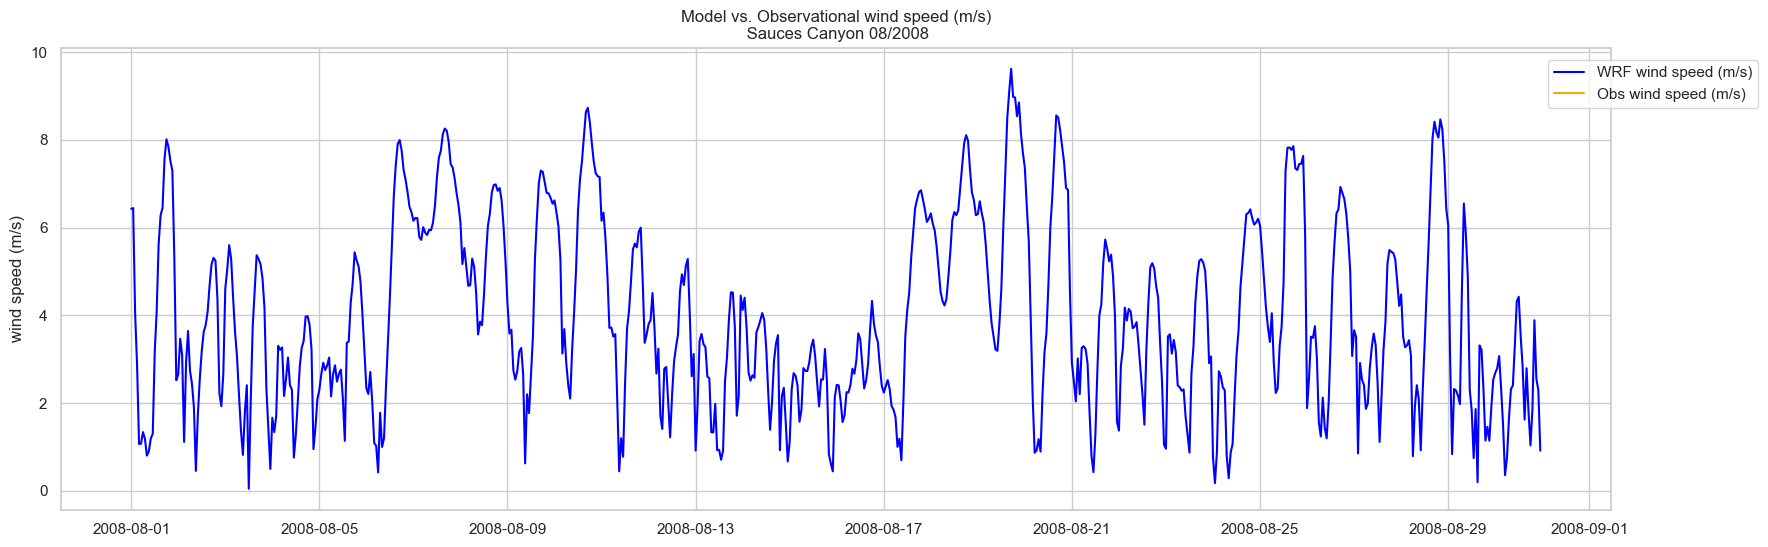

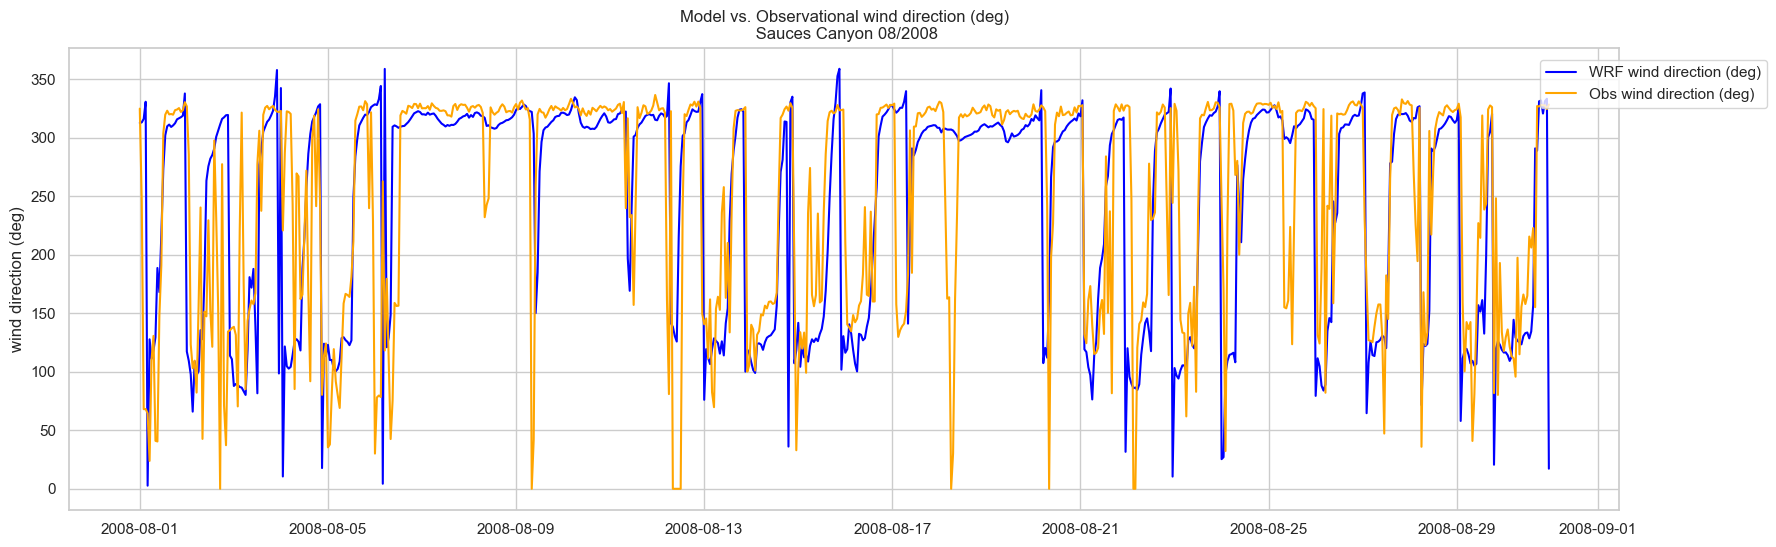

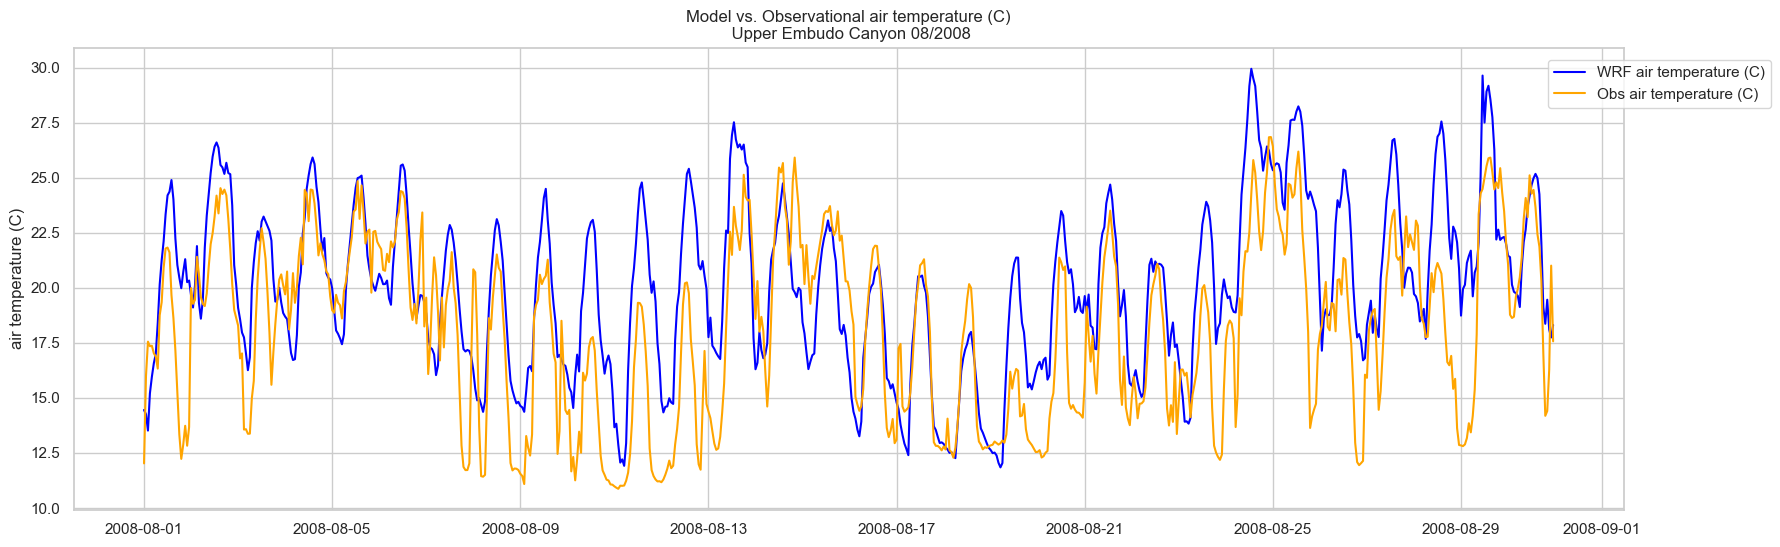

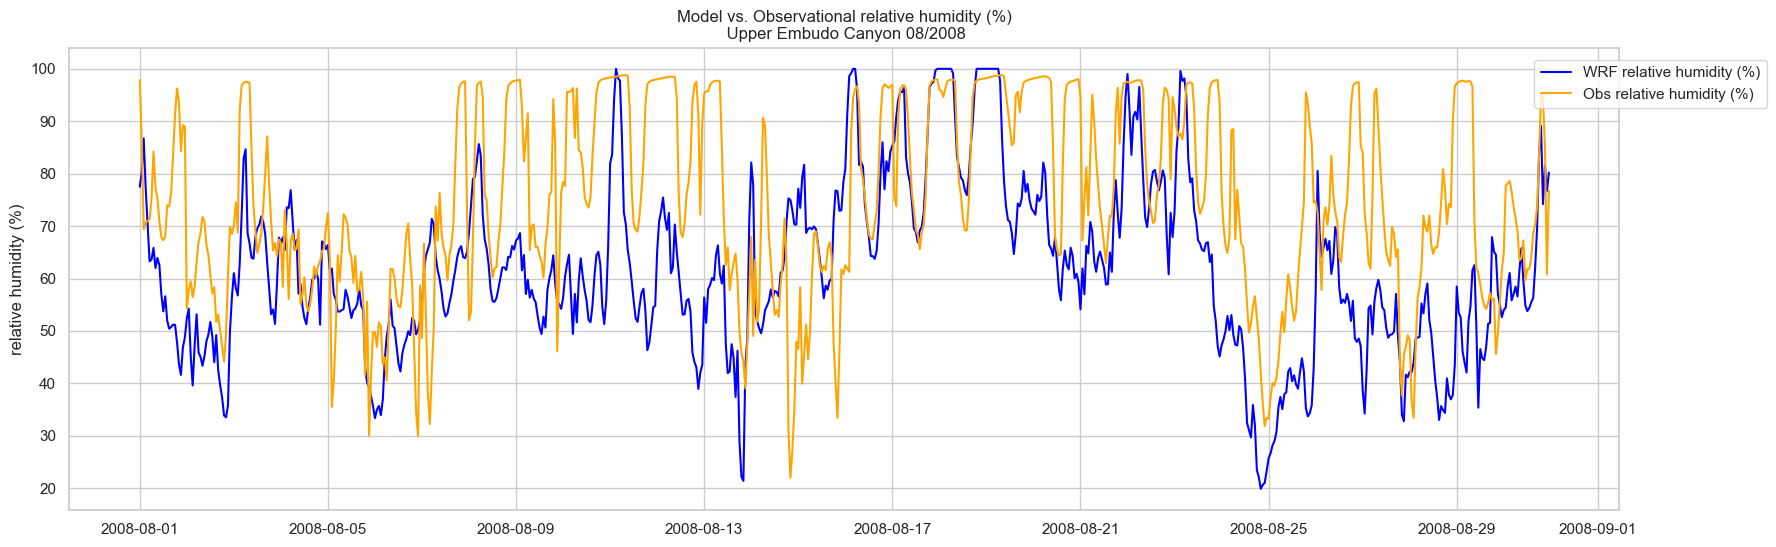

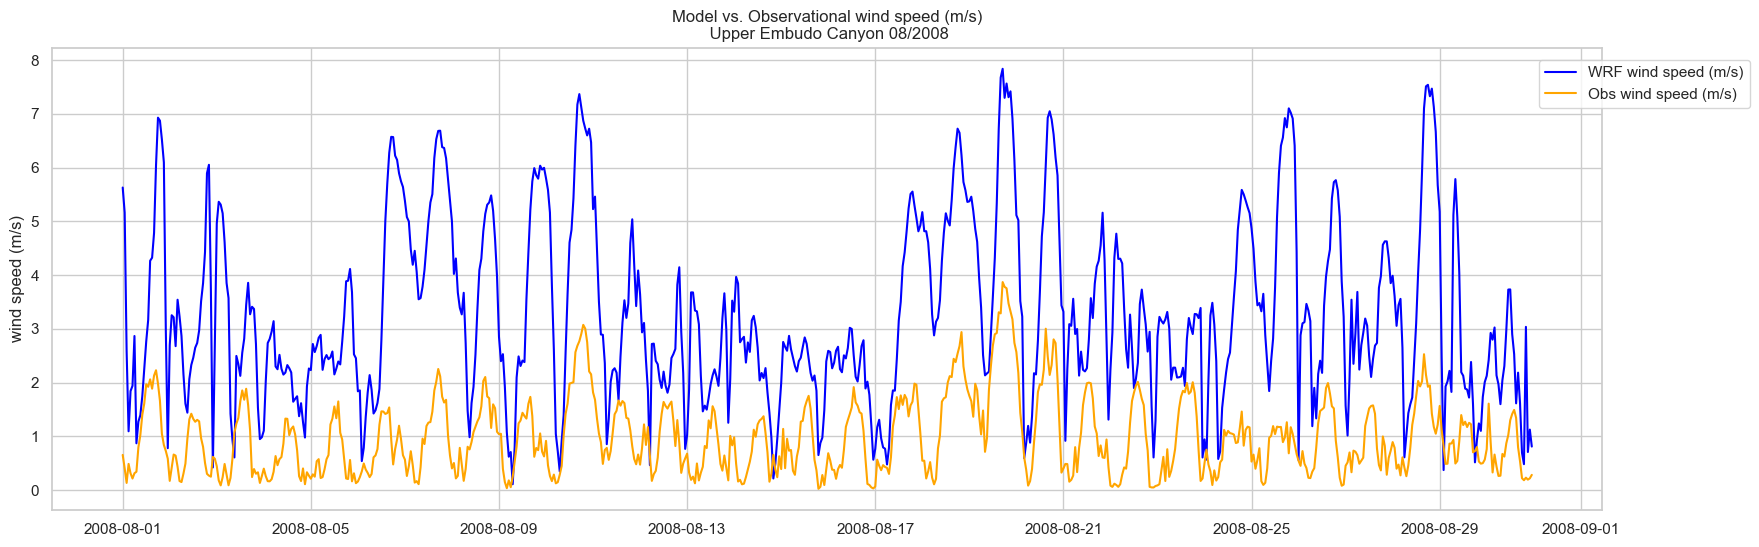

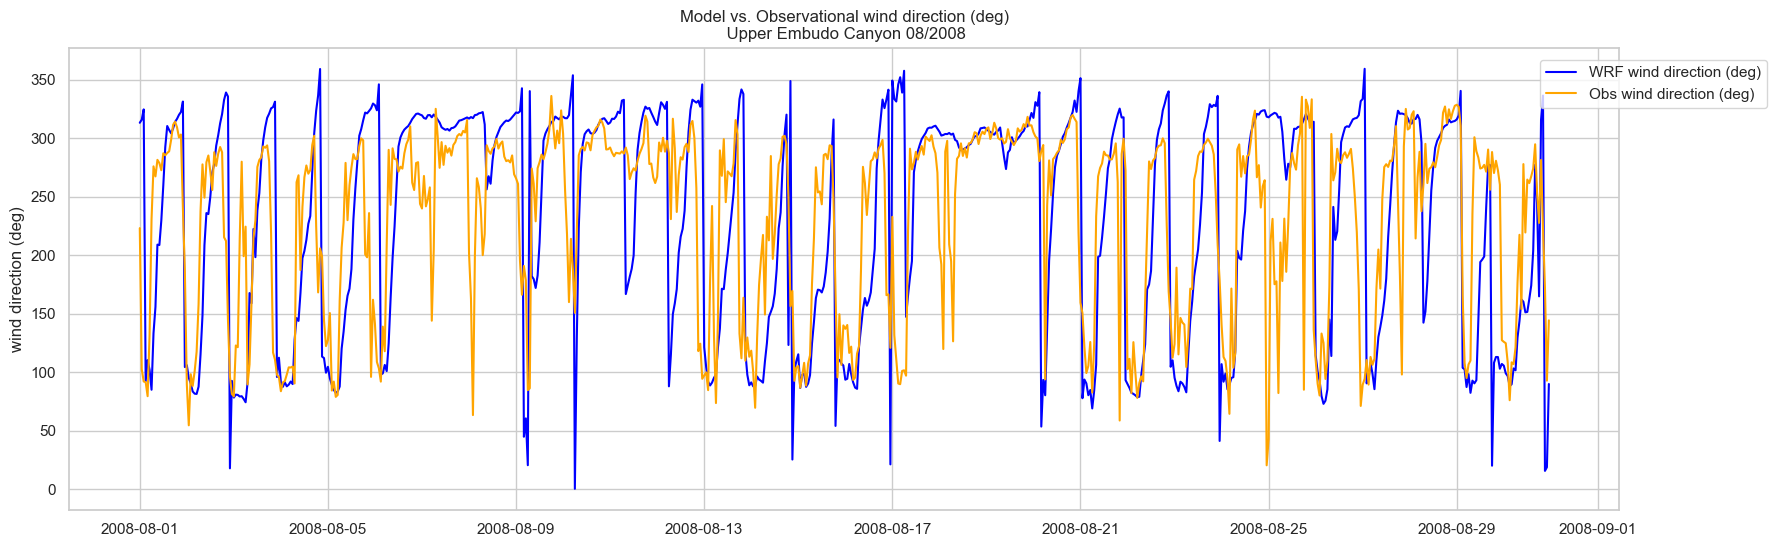

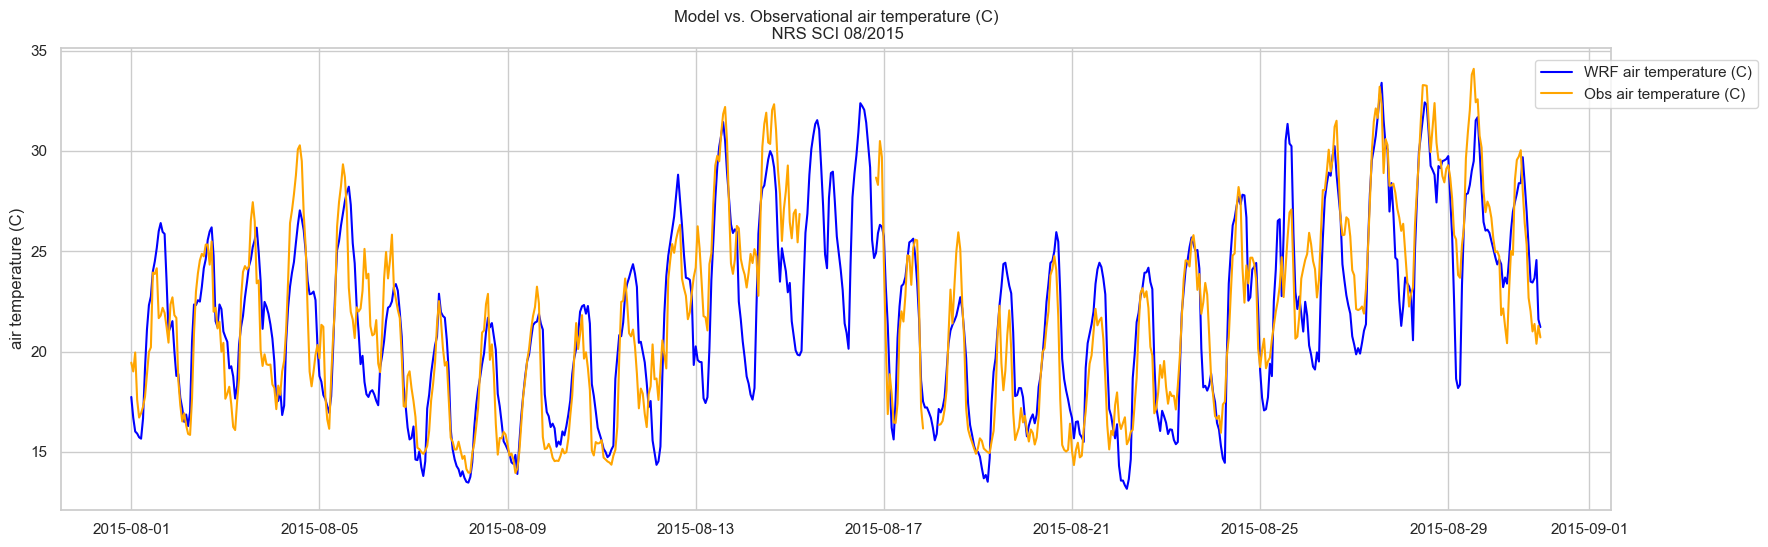

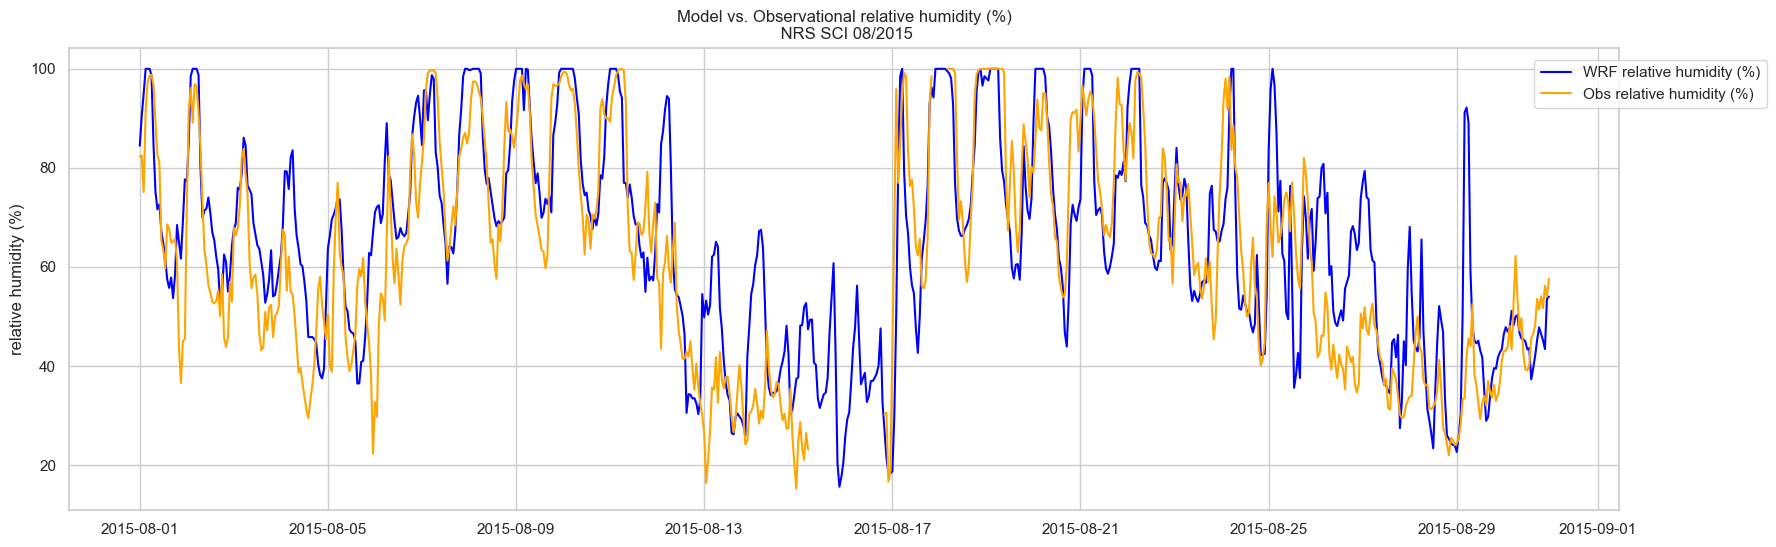

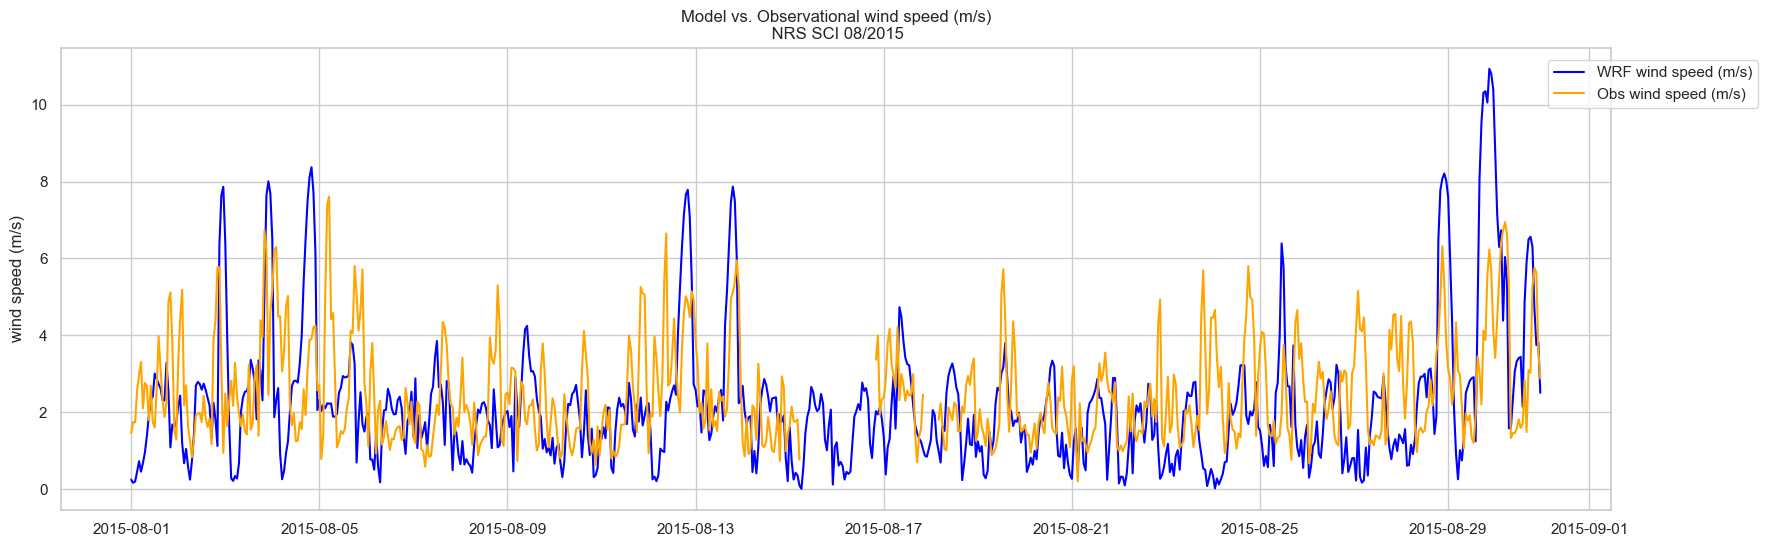

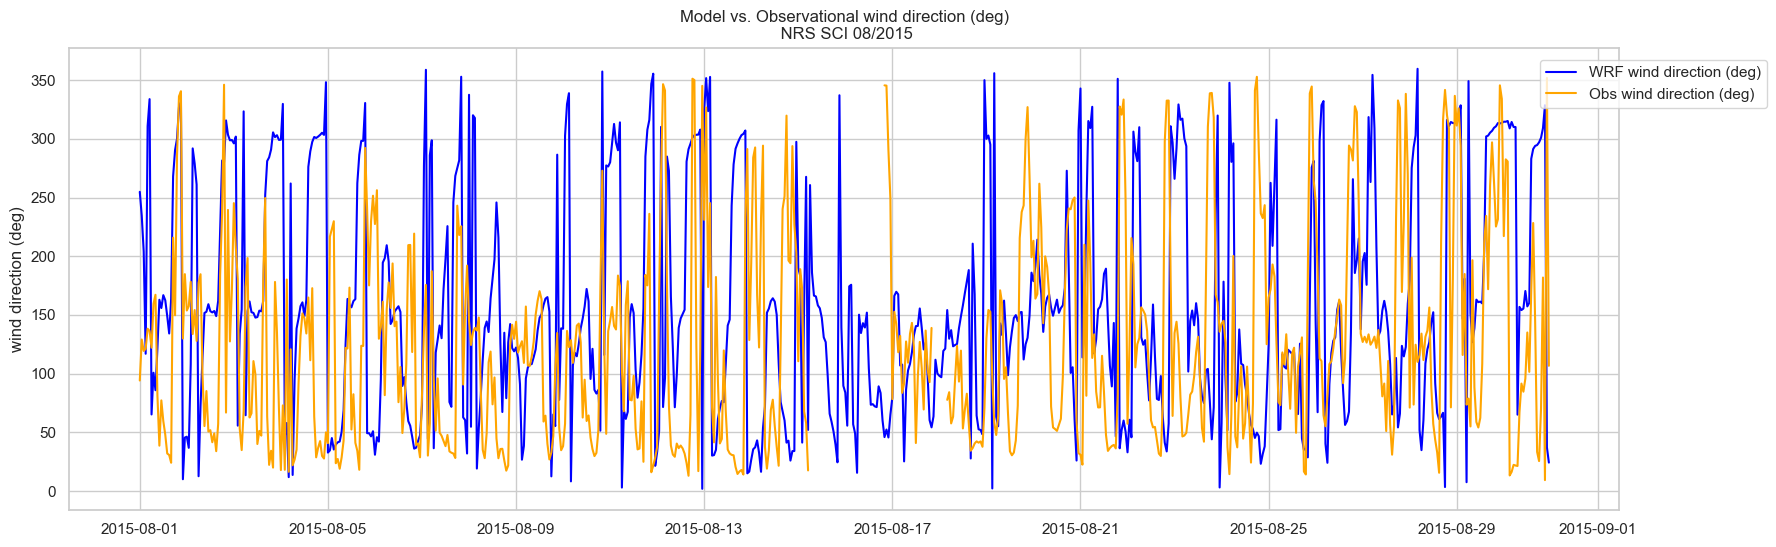

In [33]:
daterange = ['2008-08-01','2008-08-30']
nrs_daterange = ['2015-08-01', '2015-08-30']

for site in ['Sauces Canyon', 'Upper Embudo Canyon']:
    for var in variables:
        plot_timeseries(df, var, daterange, site)
        
for var in variables:
    plot_timeseries(df, var, nrs_daterange, 'NRS SCI')

# Fog Drip
Plot an overlay of WRF and observational fog occurrence over timeseries lineplot of relative humidity to assess differences. We suspect that the WRF boundary layer parameterization is leading to underprediction of stratocumulus clouds and fog. On 2008-08-25 in the plots below, we see an example of this where WRF predicted low relative humidity during a fog event. Note that the model performed better for Upper Embudo Canyon, which is relatively close but at a higher elevation than Sauces and therefore out of the clouds - indicating the model is accurately predicting what conditions would be if it weren't foggy. 

In [34]:
# Define Sauces Fog
wsauc_fog = wsauc[['fog drip', 'relative humidity (%)','source']]
osauc_fog = osauc[['fog drip', 'relative humidity (%)', 'source']]

sauc_fog = pd.concat([wsauc_fog, osauc_fog], axis=0)
sauc_fog['binary fog'] = sauc_fog['fog drip'].apply(lambda x: 1 if x > 0 else 0)
sauc_fog.head()

# Define Upem Fog
wupem_fog = wupem[['fog drip', 'relative humidity (%)','source']]
oupem_fog = oupem[['fog drip', 'relative humidity (%)', 'source']]

upem_fog = pd.concat([wupem_fog, oupem_fog], axis=0)
upem_fog['binary fog'] = upem_fog['fog drip'].apply(lambda x: 1 if x > 0 else 0)
upem_fog.head()

fog drip  relative humidity (%) source  binary fog
2002-06-30 16:00:00       0.0              86.028397    wrf           0
2002-06-30 17:00:00       0.0              69.369201    wrf           0
2002-06-30 18:00:00       0.0              63.100355    wrf           0
2002-06-30 19:00:00       0.0              69.013608    wrf           0
2002-06-30 20:00:00       0.0              68.800730    wrf           0

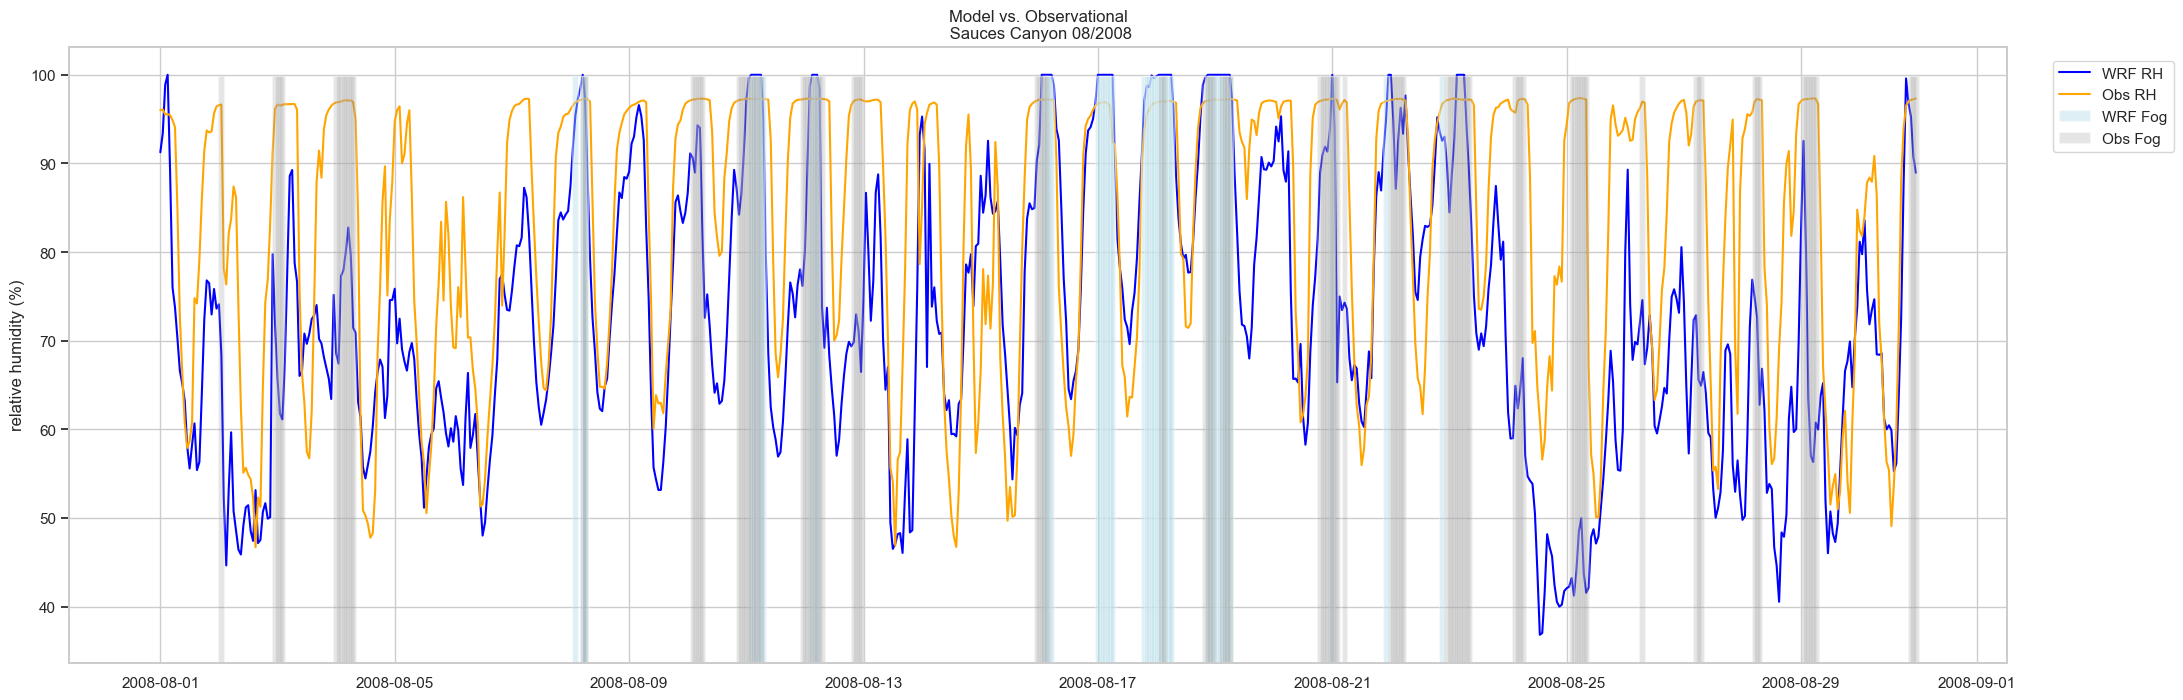

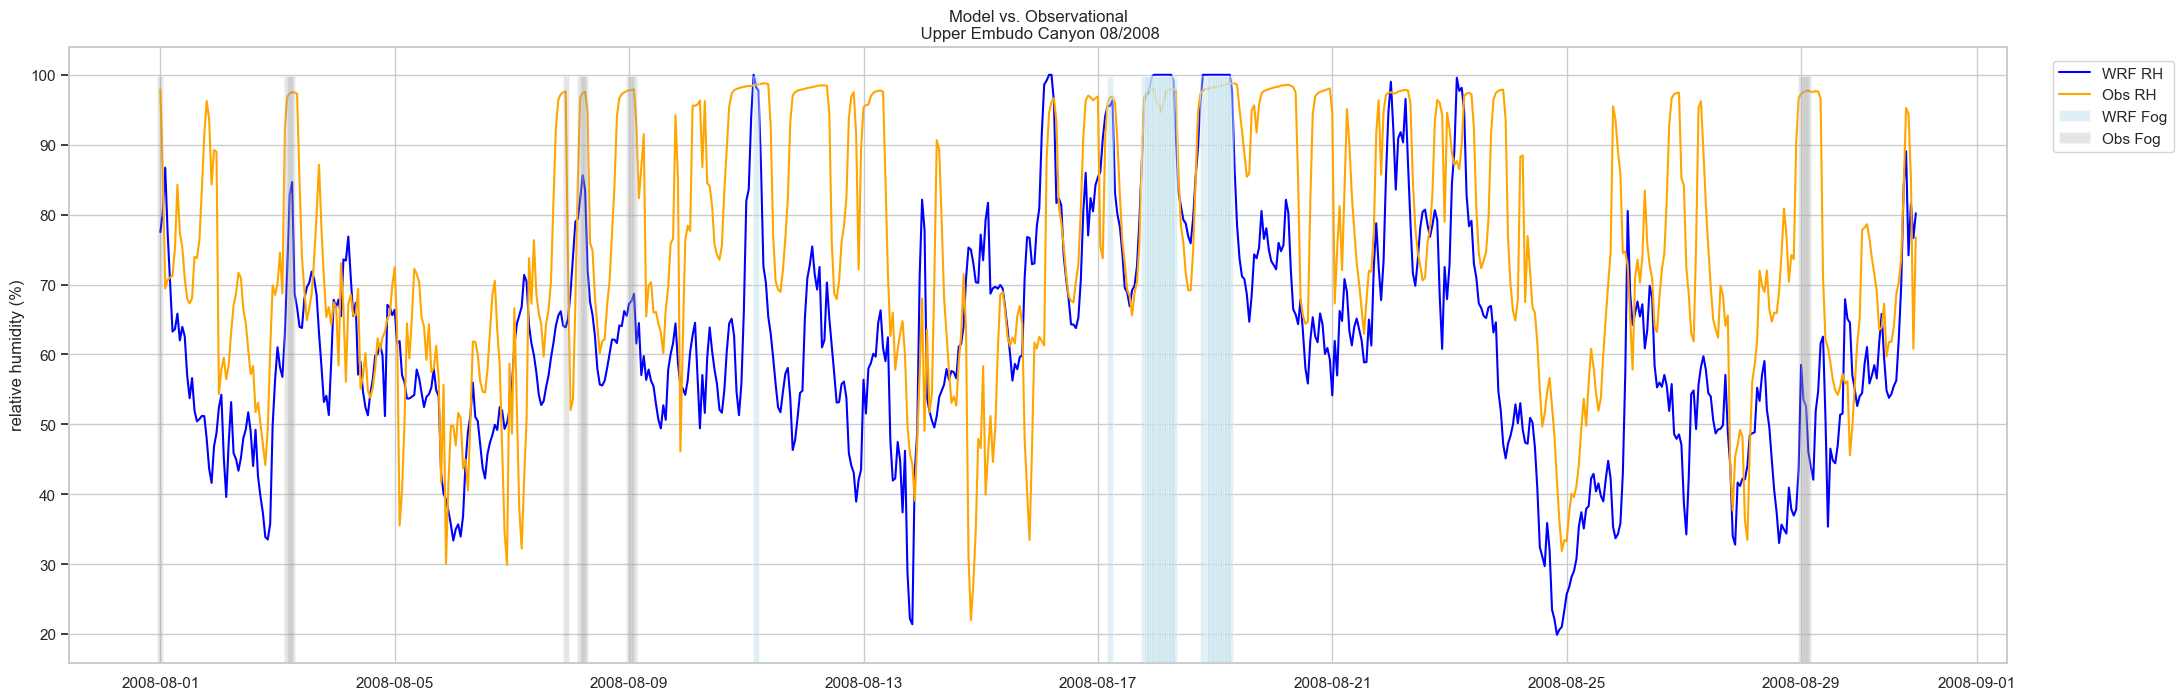

In [35]:
daterange = ['2008-08-01','2008-08-30']
plot_fog(sauc_fog, daterange, "Sauces Canyon")
plot_fog(upem_fog, daterange, "Upper Embudo Canyon")
